In [1]:
!pip install yfinance
!pip install hvplot
!pip install finta
!pip install keras-tuner
!pip install plotly

  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached peewee-3.17.8-py3-none-any.whl
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
   ---------------------------------------- 0.0/102.2 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/102.2 kB ? eta -:--:--
   ------- ------------------------------- 20.5/102.2 kB 330.3 kB/s eta 0:00:01
   ------- ------------------------------- 20.5/102.2 kB 330.3 kB/s eta 0:00:01
   ------- ------------------------------- 20.5/102.2 kB 330.3 kB/s eta 0:00:01
   ------------------------------- ------- 81.9/102.2 kB 419.2 kB/s eta 0:00:01
   ----------------------------------- --- 92.2/102.2 kB 403.5 kB/s eta 0:00:01
   -------------------------------------- 102.2/102.2 kB 347.2 kB/s eta 0:00:00
Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --- --

In [9]:
import numpy as np
from finta import TA
import pandas as pd
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from IPython.display import display
# from google.colab import files
import hvplot.pandas
import plotly.io as pio
pio.renderers.default = 'iframe'
from datetime import datetime, timedelta
import calendar
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shutil
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model


# **Technical Indicators**

In [ ]:
# For RSI
??TA.RSI

help(TA.RSI)
help(TA.MACD)
help(TA.DMI)
help(TA.MFI)
help(TA.OBV)
help(TA.WILLIAMS)
help(TA.STOCH)
help(TA.STOCHD)
help(TA.STOCHRSI)
help(TA.ADL)
help(TA.BASP)
help(TA.BASPN)
help(TA.VFI)
help(TA.MSD)
help(TA.SQZMI)
help(TA.MOM)


1. Trend Indicators
These indicators help identify the direction of the overall trend.

Moving Average Convergence Divergence (MACD): Measures the relationship between two exponential moving averages (EMAs). It provides signals for trend changes and momentum.
Directional Movement Index (DMI): Includes the Average Directional Index (ADX) and shows the strength of a trend. It’s often used with +DI and -DI lines to indicate trend direction.
Volume Flow Indicator (VFI): Uses volume to confirm trends, favoring volume-weighted trends.


2. Momentum Indicators
These measure the speed of price movements and can indicate when a trend is slowing down or reversing.

Relative Strength Index (RSI): Compares recent gains to recent losses to identify overbought or oversold conditions.
Williams %R (WILLIAMS): Similar to RSI but measures closing price relative to the high-low range, indicating overbought/oversold status.
Momentum (MOM): Calculates the difference between the current price and the price a certain number of periods ago, signaling changes in trend speed.
Stochastic Oscillator (STOCH) and Stochastic RSI (STOCHRSI): Measure momentum in relation to an asset's price range over time. STOCHRSI applies the Stochastic formula to RSI values.


3. Volume Indicators
Volume indicators analyze trading volume to confirm trends or reversals.

On-Balance Volume (OBV): Adds volume on up days and subtracts volume on down days, helping to confirm trends.
Accumulation/Distribution Line (ADL): Uses price and volume to show where money is flowing into or out of a security.


4. Volatility Indicators
These measure how much the price of an asset is moving, helping to identify periods of high and low volatility.

Squeeze Momentum Indicator (SQZMI): Combines Bollinger Bands and Keltner Channels to measure price "squeezes" and potential breakouts.
Mass Index (MSD): Detects trend reversals by looking at price range expansions. It uses the high-low range to measure volatility.


5. Others
Some indicators have unique methodologies and do not fall squarely into the above categories.

Money Flow Index (MFI): Similar to RSI but incorporates volume, making it a volume-weighted version of RSI.
Bid-Ask Spread Indicators (BASP and BASPN): Often used to measure market liquidity rather than price trend or momentum.

### **This section will allow the user to
(1) select the drive and data file to be uploaded, 

(2) prompt the user to decide and select the sheets to focus on, 

(3) prompt the user to additionaly select the securities to calculate technical indicators on, and 

(4) concantenate the features into one dataframe**

In [11]:
# SPY_2000-01-03_2024-11-09,MSFT_2000-01-03_2024-11-09,^VIX_2000-01-03_2024-11-09,^IRX_2000-01-03_2024-11-09,^TNX_2000-01-03_2024-11-09


print("Please select a CSV or Excel file to upload.")
uploaded = files.upload()

if not uploaded:
    print("No file uploaded.")
else:
    # Extract the file name
    file_name = list(uploaded.keys())[0]
    file_extension = file_name.split('.')[-1]

    if file_extension in ['xlsm', 'xlsx', 'xls']:
        # Load the sheet names
        try:
            excel_file = pd.ExcelFile(file_name)
            sheet_names = excel_file.sheet_names
            print(f"\nAvailable sheets in '{file_name}':")
            for sheet in sheet_names:
                print(sheet)
        except Exception as e:
            print(f"An error while reading the sheet names: {e}")
            sheet_names = []

        # Prompt for valid sheets to load
        sheets = []
        while not sheets:
            selected_sheets = input("\nEnter the sheet names to load, separated by commas: ").split(',')
            selected_sheets = [sheet.strip() for sheet in selected_sheets]

            # Validate selected sheet names
            invalid_sheets = [sheet for sheet in selected_sheets if sheet not in sheet_names]
            if invalid_sheets:
                print(f"Invalid sheet names: {', '.join(invalid_sheets)}. Please try again.")
            else:
                sheets = selected_sheets

        print(f"\nSelected sheets: {', '.join(sheets)}")
    else:
        print("Uploaded file is not an Excel file.")



# Load each sheet into a DataFrame and store them in list
df_list = []
for sheet in sheets:
    df = pd.read_excel(excel_file, sheet_name=sheet, index_col=0)

    # Print columns to check for the correct column name
    print(f"Columns in sheet {sheet}: {df.columns.tolist()}")
    # Check if 'date' is in the index
    if df.index.name and 'date' in df.index.name.lower():
        df['date'] = df.index
    elif 'date' in df.columns.str.lower():
        df['date'] = pd.to_datetime(df['date'])
    else:
        raise KeyError(f"Sheet '{sheet}' does not have a 'date' column or index")

    # Ensure date is datetime
    df['date'] = pd.to_datetime(df['date'])

    # Move date column to the first position
    columns = ['date'] + [col for col in df.columns if col != 'date']
    df = df[columns]

    # Columns to check for the correct column name
    print(f"Columns in sheet {sheet}: {df.columns.tolist()}")

    # Append the DataFrame to the list
    df_list.append(df)

# Sort each DataFrame by the date column in ascending order (oldest to newest)
for i, df in enumerate(df_list):
    df_list[i] = df.sort_values(by='date', ascending=True)

# Step 1: Provide a list of the sheets and prompt for selection
print("Sheets available for technical indicator calculations:")
for idx, sheet in enumerate(sheets, start=1):
    print(f"{idx}. {sheet}")

# Prompt user for sheets requiring technical indicators
selected_sheet_indices = input("Enter the numbers of the sheets for indicator calculations (comma separated, or hit 'Enter' for none): ")

# Check if the user entered anything
if selected_sheet_indices.strip():
    selected_sheet_indices = [int(i.strip()) - 1 for i in selected_sheet_indices.split(",")]
else:
    selected_sheet_indices = []

# Step 2: Loop through the selected sheets
for sheet_index in selected_sheet_indices:
    df = df_list[sheet_index]

    # Set display options to show all columns
    pd.set_option('display.max_rows', None)  # Show all rows if needed
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 0)  # Adjust to fit all content width

    # Calculate total row count and non-null count for each column
    total_length = len(df)
    column_info = pd.DataFrame({
        'Column Name': df.columns,
        'Total Length': total_length,
        'Non-Null Count': df.count()
    })
    # Print all information
    print("Column Length and Non-Null Count Information:")
    print(column_info)

    # Step 3: Store the first six column names and display them
    original_columns = df.columns[:6].tolist()
    print(f"\nOriginal columns for {sheets[sheet_index]}: {original_columns}")

    # Step 4: Temporarily rename the first six columns to standard names
    df.rename(columns=dict(zip(original_columns, ['date', 'open', 'high', 'low', 'close', 'volume'])), inplace=True)

    # Step 5: Prompt the user for a prefix
    prefix = input(f"Enter a prefix for technical indicators for {sheets[sheet_index]}: ")

    # Step 6: Calculate technical indicators and add new columns
    df[f'{prefix}_RSI'] = TA.RSI(df)
    df[f'{prefix}_MACD'] = TA.MACD(df)['MACD']
    df[f'{prefix}_Signal'] = TA.MACD(df)['SIGNAL']
    df[f'{prefix}_OBV'] = TA.OBV(df)
    df[f'{prefix}_MFI'] = TA.MFI(df)
    dmi = TA.DMI(df)
    df[f'{prefix}_DMI_plus'] = dmi['DI+']  # Positive Directional Indicator
    df[f'{prefix}_DMI_minus'] = dmi['DI-']  # Negative Directional Indicator
    df[f'{prefix}_WILLIAMS'] = TA.WILLIAMS(df)
    df[f'{prefix}_STOCH'] = TA.STOCH(df)
    df[f'{prefix}_STOCHD'] = TA.STOCHD(df)
    df[f'{prefix}_STOCHRSI'] = TA.STOCHRSI(df)
    df[f'{prefix}_ADL'] = TA.ADL(df)
    basp = TA.BASP(df)
    # df[f'{prefix}_BASP_mid'] = basp['BASP']  # Midline of BASP

    # Safely assign 'BASP_UPPER' and 'BASP_LOWER' if they exist
    if 'BASP_UPPER' in basp:
        df[f'{prefix}_BASP_upper'] = basp['BASP_UPPER']
    else:
        print(f"BASP_UPPER not found in BASP output for {prefix}, skipping column.")

    if 'BASP_LOWER' in basp:
        df[f'{prefix}_BASP_lower'] = basp['BASP_LOWER']
    baspn = TA.BASPN(df)
    for col_name in baspn.columns:
        df[f'{prefix}_BASPN_{col_name}'] = baspn[col_name]
    df[f'{prefix}_VFI'] = TA.VFI(df)
    df[f'{prefix}_MSD'] = TA.MSD(df)
    df[f'{prefix}_SQZMI'] = TA.SQZMI(df)
    df[f'{prefix}_MOM'] = TA.MOM(df)

    # Step 7: Rename the columns back to their original names
    df.rename(columns=dict(zip(['date', 'open', 'high', 'low', 'close', 'volume'], original_columns)), inplace=True)

    print(f"\nUpdated DataFrame for {sheets[sheet_index]} with technical indicators added:\n")
    display(df.tail(5))  # Display the last few rows of the updated DataFrame

# Final print to indicate completion of all updates
print("\nAll selected datasets have been updated with technical indicators.")


# Set display options
pd.set_option('display.max_columns', None)  # Show all columns in one row
pd.set_option('display.width', 0)           # Automatically adjust to fit width

# Select sheets for concatenation
print("Sheets available for selection:")
for i, sheet in enumerate(sheets, start=1):
    print(f"{i}. {sheet}")

selected_sheets = input("Enter the sheet numbers to concatenate (comma separated): ")
selected_sheets = [int(x.strip()) - 1 for x in selected_sheets.split(",")]

# Select the corresponding DataFrames based on user input
selected_dfs = [df_list[i] for i in selected_sheets]

# Concatenate selected DataFrames on 'date' column, keeping only matching dates
merged_df = selected_dfs[0]
for df in selected_dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='date', how='inner')

#index the date
merged_df = merged_df.set_index('date', drop=False)



# Set display options to show all columns
pd.set_option('display.max_rows', None)  # Show all rows if needed
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)  # Adjust to fit all content width

# Calculate total row count and non-null count for each column
total_length = len(merged_df)
column_info = pd.DataFrame({
    'Column Name': merged_df.columns,
    'Total Length': total_length,
    'Non-Null Count': merged_df.count()
})
# Print all information
print("Column Length and Non-Null Count Information:")
print(column_info)


# Drop rows with missing values (NaN)
# merged_df.dropna(inplace=True)


Please select a CSV or Excel file to upload.


NameError: name 'files' is not defined

# **This section will allow the user to select which features to expand on daily volatility (rolling 15 day average) and daily price changes, and compare the price of the target security 5 days out and determine if it is 5% below or above current rows price and label them accordingly (1,0 -1)**

In [19]:

# Display the columns available
columns = merged_df.columns.tolist()

# Split columns into three groups for display
num_columns = len(columns)
columns_per_group = math.ceil(num_columns / 3)

# Format columns for display
column_groups = [columns[i:i + columns_per_group] for i in range(0, num_columns, columns_per_group)]

# Calculate the maximum length of columns in any group
max_length = max(len(group) for group in column_groups)
column_width = max(len(col) for group in column_groups for col in group) + 2  # Add padding

print("\nColumns available in the merged DataFrame (side by side with continuous numbering):")

# Initialize the column number
column_number = 1

# Loop through the rows of the groups and print them side by side
for i in range(max_length):
    j = 0
    for group in column_groups:
        j += 1
        if i < len(group):
            if j == 1:
                # Print the column number for the first group in the row
                print(f"{column_number: <4}. {group[i]: <{column_width}}", end=" | ")
                column_number += 1
            elif j == 2:
                # Offset numbering for the second group
                print(f"{column_number + (max_length - 1): <4}. {group[i]: <{column_width}}", end=" | ")
            elif j == 3:
                # Offset numbering for the third group
                print(f"{column_number + ((2 * max_length) - 1): <4}. {group[i]: <{column_width}}", end=" | ")
        else:
            # Print empty spaces if the group has fewer columns
            print(" " * (column_width + 8), end=" | ")
    print()  # Add newline after each row

# -----------------------------------------------------------------------------------
# Part 1: Calculate Daily Price Changes and 15-Day Average Daily Volatility
# -----------------------------------------------------------------------------------

# Prompt the user to select columns for calculating daily price changes
selected_change_numbers = input("\nEnter the column numbers to calculate daily price changes (comma separated): ")
selected_change_columns = [columns[int(num.strip()) - 1] for num in selected_change_numbers.split(",")]

# Calculate daily price changes and 15-day average daily volatility
for col in selected_change_columns:
    # Calculate daily percentage change
    daily_change_col = f"{col}_daily_change"
    merged_df[daily_change_col] = merged_df[col].pct_change() * 100  # Percentage change

    # Calculate 15-day average daily volatility (standard deviation of daily changes)
    volatility_col = f"{col}_10d_volatility"
    merged_df[volatility_col] = merged_df[daily_change_col].rolling(window=15).std()

print("\nNew columns added for daily price changes and 15-day average daily volatility:")
for col in selected_change_columns:
    print(f"- {col}_daily_change")
    print(f"- {col}_10d_volatility")

# Display a preview of the new columns
preview_cols = []
for col in selected_change_columns:
    preview_cols.extend([f"{col}_daily_change", f"{col}_10d_volatility"])
print("\nPreview of the new columns:")
print(merged_df[preview_cols].head())

# -----------------------------------------------------------------------------------
# Part 2: Calculate 5-Day Forward Price Changes with Labels
# -----------------------------------------------------------------------------------

# Prompt the user to select columns for calculating 5-day forward price changes
selected_forward_change_numbers = input("\nEnter the column numbers to calculate 5-day forward price changes (comma separated): ")
selected_forward_change_columns = [columns[int(num.strip()) - 1] for num in selected_forward_change_numbers.split(",")]

# Calculate 5-day forward price changes and label them
for col in selected_forward_change_columns:
    # Calculate the price change compared to 2 days ahead
    future_change_col = f"{col}_change_5d"
    merged_df[future_change_col] = ((merged_df[col].shift(-5) - merged_df[col]) / merged_df[col]) * 100  # Percentage change

    # Create labels based on the change
    label_col = f"{col}_change_5d_label"
    merged_df[label_col] = merged_df[future_change_col].apply(
        lambda x: 1 if x >= 2 else (-1 if x <= -2 else 0)
    )

print("\nNew columns added for 5-day forward price changes with labels:")
for col in selected_forward_change_columns:
    print(f"- {col}_change_5d")
    print(f"- {col}_change_5d_label")

# Display a preview of the new forward change columns
forward_preview_cols = []
for col in selected_forward_change_columns:
    forward_preview_cols.extend([f"{col}_change_5d", f"{col}_change_5d_label"])
print("\nPreview of the new forward change columns:")
print(merged_df[forward_preview_cols].head(15))  # Show more rows to see the forward changes

# -----------------------------------------------------------------------------------
# Part 3: Save the Updated DataFrame
# -----------------------------------------------------------------------------------

# save the updated DataFrame to a new Excel file
save_option = input("\nDo you want to save the updated DataFrame to an Excel file? (yes/no): ").strip().lower()
if save_option == 'yes':
    output_filename = input("Enter the filename (e.g., updated_stock_data.xlsx): ").strip()
    # Ensure the filename has the correct Excel extension
    if not output_filename.endswith('.xlsx'):
        output_filename += '.xlsx'

    merged_df.to_excel(output_filename)
    print(f"DataFrame saved to {output_filename}")
else:
    print("DataFrame not saved.")



# Set display options to show all columns
pd.set_option('display.max_rows', None)  # Show all rows if needed
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)  # Adjust to fit all content width

# Calculate total row count and non-null count for each column
total_length = len(merged_df)
column_info = pd.DataFrame({
    'Column Name': merged_df.columns,
    'Total Length': total_length,
    'Non-Null Count': merged_df.count()
})
# Print all information
print("Column Length and Non-Null Count Information:")
print(column_info)


Columns available in the merged DataFrame (side by side with continuous numbering):
1   . date                         | 23  . SPY-Volume                   | 45  . XOM-Low                      | 
2   . Open                         | 24  . RSI_x                        | 46  . XOM-Close                    | 
3   . High                         | 25  .  + Directional indicator_x   | 47  . XOM-Volume                   | 
4   . Low                          | 26  .  -Directiomal Indicaor_x     | 48  . RSI_y                        | 
5   . Close                        | 27  . Momentum_x                   | 49  .  + Directional indicator_y   | 
6   . 1 Mo                         | 28  . Money Flow index_x           | 50  .  -Directiomal Indicaor_y     | 
7   . 2 Mo                         | 29  . OBV_x                        | 51  . Momentum_y                   | 
8   . 3 Mo                         | 30  . EMA_x                        | 52  . Money Flow index_y           | 
9   . 4 Mo         

# **Prompt the user to select and prepare scatter plots**

In [20]:
# merged_df.set_index('date', inplace=false)
merged_df = merged_df.set_index('date', drop=False)


Columns available in the merged DataFrame (side by side with continuous numbering):
1   . date                         | 25  .  + Directional indicator_x   | 49  .  + Directional indicator_y   | 
2   . Open                         | 26  .  -Directiomal Indicaor_x     | 50  .  -Directiomal Indicaor_y     | 
3   . High                         | 27  . Momentum_x                   | 51  . Momentum_y                   | 
4   . Low                          | 28  . Money Flow index_x           | 52  . Money Flow index_y           | 
5   . Close                        | 29  . OBV_x                        | 53  . OBV_y                        | 
6   . 1 Mo                         | 30  . EMA_x                        | 54  . EMA_y                        | 
7   . 2 Mo                         | 31  . William R Indicator_x        | 55  . William R Indicator_y        | 
8   . 3 Mo                         | 32  . SMA_x                        | 56  . SMA_y                        | 
9   . 4 Mo         

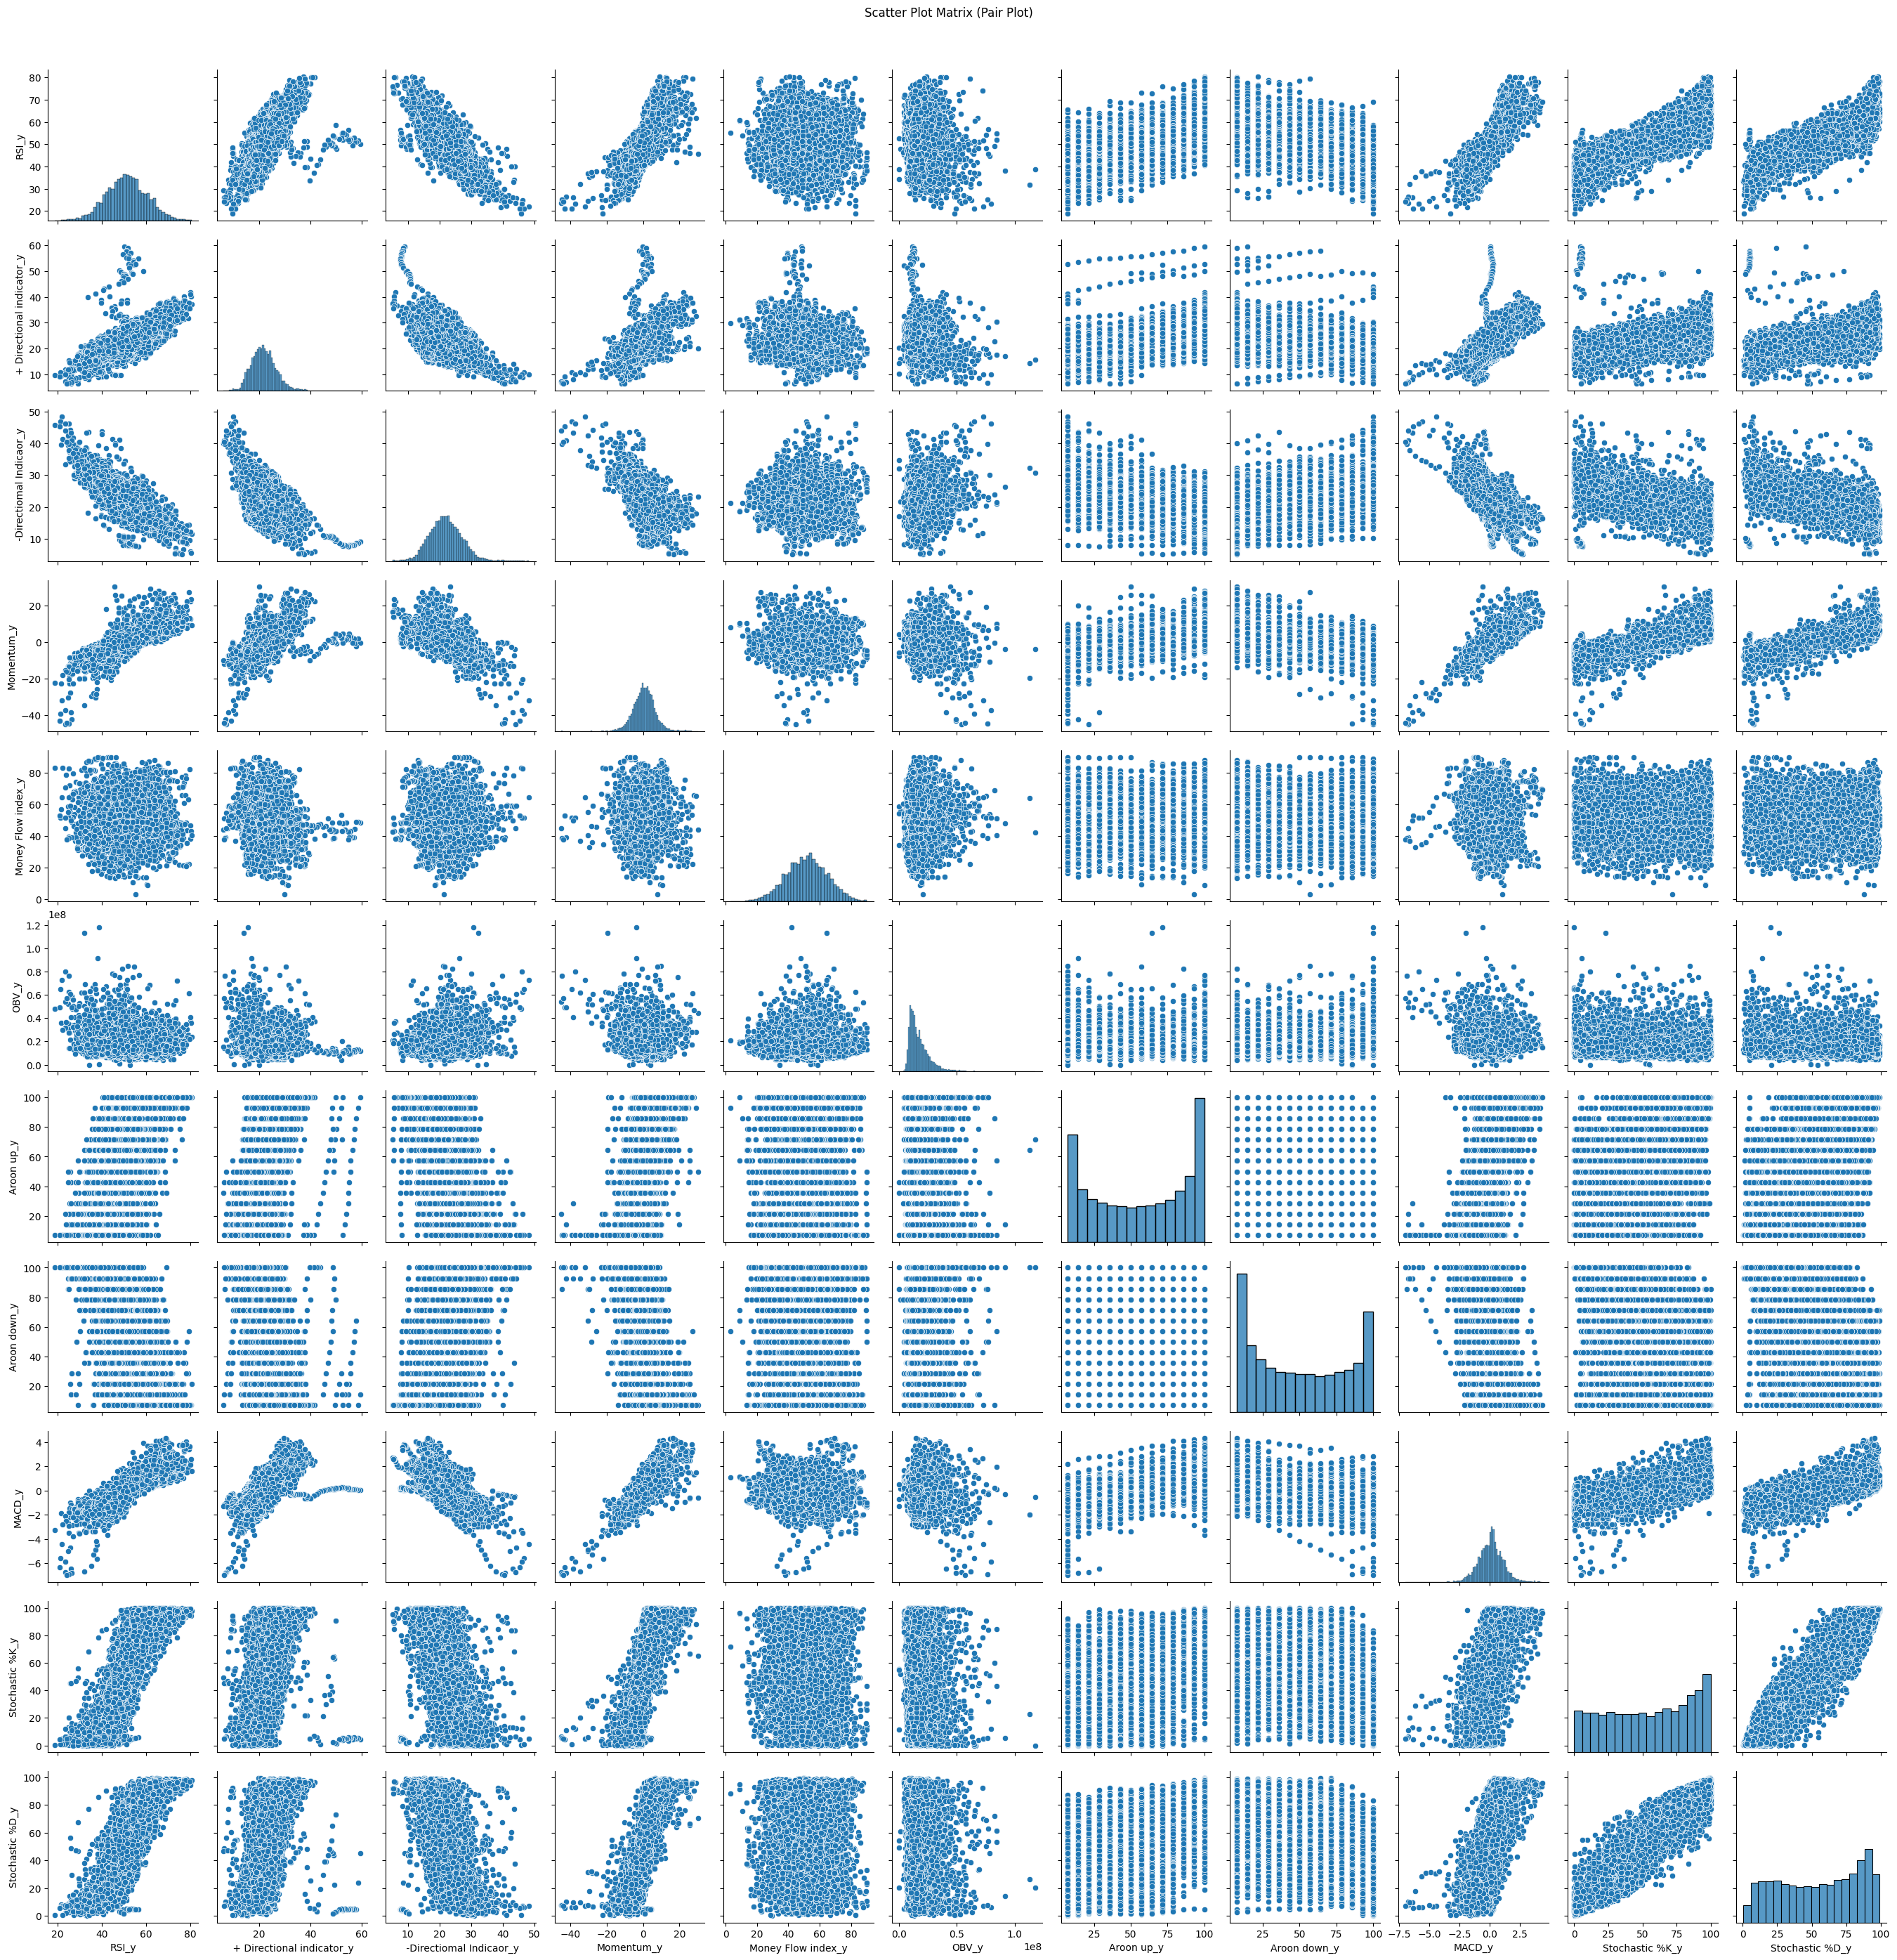

In [ ]:

# Display the columns available
columns = merged_df.columns.tolist()

# Split columns into three groups
num_columns = len(columns)
columns_per_group = math.ceil(num_columns / 3)

# Format columns into three groups for display
column_groups = [columns[i:i + columns_per_group] for i in range(0, num_columns, columns_per_group)]

# Calculate the maximum length of columns in any group
max_length = max(len(group) for group in column_groups)
column_width = max(len(col) for group in column_groups for col in group) + 2  # Add padding

print("\nColumns available in the merged DataFrame (side by side with continuous numbering):")

# Initialize the column number to start from 1
column_number = 1

# Loop through the rows of groups and print them side by side
for i in range(max_length):
    j = 0
    for group in column_groups:
        j += 1
        if i < len(group):
            if j == 1:
                # Print the column number for the first group in the row
                print(f"{column_number: <4}. {group[i]: <{column_width}}", end=" | ")
                column_number += 1
            elif j == 2:
                # Offset numbering for the second group
                print(f"{column_number + (max_length - 1): <4}. {group[i]: <{column_width}}", end=" | ")
            elif j == 3:
                # Offset numbering for the third group
                print(f"{column_number + ((2 * max_length) - 1): <4}. {group[i]: <{column_width}}", end=" | ")
        else:
            # Print empty spaces if the group has fewer columns
            print(" " * (column_width + 8), end=" | ")
    print()  # Add newline after each row

# # Prompt for scatter plot columns
# selected_column_numbers = input("Enter the column numbers for scatter plots (comma separated): ")
# selected_scatter_columns = [columns[int(num) - 1] for num in selected_column_numbers.split(",")]

while True:
    try:
        # Prompt for scatter plot columns
        selected_column_numbers = input("\nEnter the column numbers for scatter plots (comma-separated): ")
        selected_column_numbers = [num.strip() for num in selected_column_numbers.split(",")]

        # Ensure all inputs are valid integers and within the correct range
        if all(num.isdigit() and 1 <= int(num) <= num_columns for num in selected_column_numbers):
            selected_scatter_columns = [columns[int(num) - 1] for num in selected_column_numbers]
            break
        else:
            print(f"Invalid input. Please enter numbers between 1 and {num_columns}, separated by commas.")
    except ValueError:
        print("An error occurred. Please enter valid integer column numbers.")

print("\nSelected columns for scatter plots:", selected_scatter_columns)


# Generate a pair plot using seaborn
def generate_pairplot(df, columns):
    sns.pairplot(df[columns])
    plt.suptitle("Scatter Plot Matrix (Pair Plot)", y=1.02)  # Add a title above the plot
    plt.show()

# Create the pair plot
generate_pairplot(merged_df, selected_scatter_columns)


In [13]:
import plotly.express as px
import pandas as pd

# Enable Plotly to work in Google Colab
import plotly.io as pio
pio.renderers.default = 'colab'


# Display the columns available
columns = merged_df.columns.tolist()

# Split columns into three groups
num_columns = len(columns)
columns_per_group = math.ceil(num_columns / 3)

# Format columns into three groups
column_groups = [columns[i:i + columns_per_group] for i in range(0, num_columns, columns_per_group)]

# Calculate the maximum length of columns in any group
max_length = max(len(group) for group in column_groups)
column_width = max(len(col) for group in column_groups for col in group) + 2  # Add padding

print("\nColumns available in the merged DataFrame (side by side with continuous numbering):")

# Initialize the column number to start from 1
column_number = 1

# Loop through the rows of the groups and print them side by side
for i in range(max_length):
    j = 0
    for group in column_groups:
        j += 1
        if i < len(group):
            if j == 1:
                # Print the column number for the first group in the row
                print(f"{column_number: <4}. {group[i]: <{column_width}}", end=" | ")
                column_number += 1
            elif j == 2:
                # Offset numbering for the second group
                print(f"{column_number + (max_length - 1): <4}. {group[i]: <{column_width}}", end=" | ")
            elif j == 3:
                # Offset numbering for the third group
                print(f"{column_number + ((2 * max_length) - 1): <4}. {group[i]: <{column_width}}", end=" | ")
        else:
            # Print empty spaces if the group has fewer columns
            print(" " * (column_width + 8), end=" | ")
    print()  # Add newline after each row

# Prompt for column selection for line plots
selected_column_numbers = input("Enter the column numbers for line plots (comma separated): ")
selected_line_columns = [columns[int(num) - 1] for num in selected_column_numbers.split(",")]

# Function to generate line plots, group and individual
def generate_line_plots(df, individual_columns, overlay_groups):
    # Determine total rows
    total_rows = len(individual_columns) + len(overlay_groups)
    fig = make_subplots(rows=total_rows, cols=1, shared_xaxes=True, vertical_spacing=0.02)

    row = 1
    # Plot each individual column
    for col in individual_columns:
        fig.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=col), row=row, col=1)
        row += 1

    # Plot each overlay group
    for group in overlay_groups:
        for col in group:
            fig.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=col), row=row, col=1)
        row += 1

    fig.update_layout(title="Interactive Line Plots", height=400 * total_rows)
    fig.show()

# Interactive prompt to specify columns to overlay
individual_columns = selected_line_columns[:]
overlay_groups = []

while True:
    overlay_input = input("Enter column numbers to overlay together (comma separated), or 'done' if finished: ").strip()

    if overlay_input.lower() == 'done':
        break

    try:
        # Process input and filter empty entries
        overlay_indices = [int(num.strip()) - 1 for num in overlay_input.split(",") if num.strip()]

        # Validate indices
        if all(0 <= idx < len(columns) for idx in overlay_indices):
            overlay_columns = [columns[idx] for idx in overlay_indices]

            # Add to overlay groups
            overlay_groups.append(overlay_columns)

            # Remove from individual columns
            individual_columns = [col for col in individual_columns if col not in overlay_columns]
        else:
            print(f"Invalid input: Numbers must be between 1 and {len(columns)}.")
    except ValueError:
        print("Invalid input: Please enter valid integers separated by commas.")

# Generate plots based on selections
generate_line_plots(merged_df, individual_columns, overlay_groups)


Columns available in the merged DataFrame (side by side with continuous numbering):
1   . date                         | 25  .  + Directional indicator_x   | 49  .  + Directional indicator_y   | 
2   . Open                         | 26  .  -Directiomal Indicaor_x     | 50  .  -Directiomal Indicaor_y     | 
3   . High                         | 27  . Momentum_x                   | 51  . Momentum_y                   | 
4   . Low                          | 28  . Money Flow index_x           | 52  . Money Flow index_y           | 
5   . Close                        | 29  . OBV_x                        | 53  . OBV_y                        | 
6   . 1 Mo                         | 30  . EMA_x                        | 54  . EMA_y                        | 
7   . 2 Mo                         | 31  . William R Indicator_x        | 55  . William R Indicator_y        | 
8   . 3 Mo                         | 32  . SMA_x                        | 56  . SMA_y                        | 
9   . 4 Mo         

# **Prompt the user to delete any unnecessary feature columns**

In [22]:

# Display the columns available
columns = merged_df.columns.tolist()

# Split columns into three groups
num_columns = len(columns)
columns_per_group = math.ceil(num_columns / 3)

# Format columns into three groups for display
column_groups = [columns[i:i + columns_per_group] for i in range(0, num_columns, columns_per_group)]

# Calculate the maximum length of columns in any group
max_length = max(len(group) for group in column_groups)
column_width = max(len(col) for group in column_groups for col in group) + 2  # Add padding for readability

print("\nColumns available in the merged DataFrame (side by side with continuous numbering):")

# Initialize the column number to start from 1
column_number = 1

# Loop through the rows of the groups and print them side by side
for i in range(max_length):
    j = 0
    for group in column_groups:
        j += 1
        if i < len(group):
            if j == 1:
                # Print the column number for the first group in the row
                print(f"{column_number: <4}. {group[i]: <{column_width}}", end=" | ")
                column_number += 1
            elif j == 2:
                # Offset numbering for the second group
                print(f"{column_number + (max_length - 1): <4}. {group[i]: <{column_width}}", end=" | ")
            elif j == 3:
                # Offset numbering for the third group
                print(f"{column_number + ((2 * max_length) - 1): <4}. {group[i]: <{column_width}}", end=" | ")
        else:
            # Print empty spaces if the group has fewer columns
            print(" " * (column_width + 8), end=" | ")
    print()  # Add newline after each row

# Prompt the user to enter column numbers to delete
selected_change_columns = input("Enter the column numbers to delete (comma separated, or press Enter to skip): ")

# Proceed if user provides input
if selected_change_columns:
    # Convert selected column numbers to column names
    selected_columns_to_delete = [columns[int(num) - 1] for num in selected_change_columns.split(",")]

    # Delete the selected columns
    merged_df.drop(columns=selected_columns_to_delete, inplace=True)
    print("Selected columns have been deleted.")
else:
    print("No columns were selected for deletion.")


Columns available in the merged DataFrame (side by side with continuous numbering):
1   . date                         | 25  .  + Directional indicator_x   | 49  .  + Directional indicator_y   | 
2   . Open                         | 26  .  -Directiomal Indicaor_x     | 50  .  -Directiomal Indicaor_y     | 
3   . High                         | 27  . Momentum_x                   | 51  . Momentum_y                   | 
4   . Low                          | 28  . Money Flow index_x           | 52  . Money Flow index_y           | 
5   . Close                        | 29  . OBV_x                        | 53  . OBV_y                        | 
6   . 1 Mo                         | 30  . EMA_x                        | 54  . EMA_y                        | 
7   . 2 Mo                         | 31  . William R Indicator_x        | 55  . William R Indicator_y        | 
8   . 3 Mo                         | 32  . SMA_x                        | 56  . SMA_y                        | 
9   . 4 Mo         

# **Review the data points for each feature column**

In [25]:
# Set display options to show all columns
pd.set_option('display.max_rows', None)  # Show all rows if needed
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)  # Adjust to fit all content width

# Calculate total row count and non-null count for each column
total_length = len(merged_df)
column_info = pd.DataFrame({
    'Column Name': merged_df.columns,
    'Total Length': total_length,
    'Non-Null Count': merged_df.count()
})
# Print all information
print("Column Length and Non-Null Count Information:")
print(column_info)

Column Length and Non-Null Count Information:
                                           Column Name  Total Length  Non-Null Count
date                                              date          5779            5779
Open                                              Open          5779            5779
High                                              High          5779            5779
Low                                                Low          5779            5779
Close                                            Close          5779            5779
1 Mo                                              1 Mo          5779            5779
3 Mo                                              3 Mo          5779            5779
6 Mo                                              6 Mo          5779            5779
1 Yr                                              1 Yr          5779            5779
2 Yr                                              2 Yr          5779            5779
3 Yr               

# **Remove any non-value rows**

In [24]:
# Split the dataframe into two parts: all rows except the last 10,
main_df = merged_df.iloc[:-10]
last_10_rows = merged_df.tail(10)

# Drop rows with NaN values in the main portion of the dataframe
main_df.dropna(inplace=True)

# Concatenate the cleaned main portion with the preserved last 10 rows
merged_df = pd.concat([main_df, last_10_rows], ignore_index=True)


# Set display options to show all columns
pd.set_option('display.max_rows', None)  # Show all rows if needed
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)  # Adjust to fit all content width

# Calculate total row count and non-null count for each column
total_length = len(merged_df)
column_info = pd.DataFrame({
    'Column Name': merged_df.columns,
    'Total Length': total_length,
    'Non-Null Count': merged_df.count()
})
# Print all information
print("Column Length and Non-Null Count Information:")
print(column_info)

Column Length and Non-Null Count Information:
                                           Column Name  Total Length  Non-Null Count
date                                              date          5779            5779
Open                                              Open          5779            5779
High                                              High          5779            5779
Low                                                Low          5779            5779
Close                                            Close          5779            5779
1 Mo                                              1 Mo          5779            5779
3 Mo                                              3 Mo          5779            5779
6 Mo                                              6 Mo          5779            5779
1 Yr                                              1 Yr          5779            5779
2 Yr                                              2 Yr          5779            5779
3 Yr               

<ipython-input-24-673151e59d10>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:

print(merged_df.tail(10))


           date   Open   High    Low  Close  1 Mo  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  \
5769 2024-09-23  16.71  16.95  15.75  15.89  4.85  4.72  4.40  3.91  3.57  3.47  3.51  3.62   
5770 2024-09-24  15.87  16.67  15.27  15.39  4.78  4.69  4.36  3.88  3.49  3.44  3.47  3.60   
5771 2024-09-25  15.82  15.82  15.17  15.41  4.79  4.69  4.36  3.89  3.53  3.49  3.52  3.65   
5772 2024-09-26  15.06  15.83  14.90  15.37  4.90  4.68  4.38  3.96  3.60  3.54  3.55  3.65   
5773 2024-09-27  15.64  16.97  15.20  16.96  4.90  4.68  4.35  3.90  3.55  3.49  3.50  3.60   
5774 2024-09-30  17.01  17.79  16.47  16.73  4.93  4.73  4.38  3.98  3.66  3.58  3.58  3.67   
5775 2024-10-01  16.96  20.73  16.61  19.26  4.96  4.71  4.36  3.96  3.61  3.52  3.51  3.60   
5776 2024-10-02  19.65  20.36  18.58  18.90  4.92  4.69  4.36  3.97  3.63  3.54  3.55  3.65   
5777 2024-10-03  19.63  20.75  19.16  20.49  4.99  4.68  4.37  4.02  3.70  3.62  3.62  3.71   
5778 2024-10-04  20.48  20.48  18.48  19.21  5.01 

In [28]:
import pandas as pd
import plotly.graph_objects as go

# Define the prefix for the stock symbol
symbol_prefix = "XOM"

# Enable Plotly to work in Google Colab
import plotly.io as pio
pio.renderers.default = 'colab'

# Check if the columns 'SPY-Close' and 'SPY-Close_change_5d_label_2' exist
close_column = f'{symbol_prefix}-Close'
change_label_column = f'{symbol_prefix}-Close_change_5d_label'

if close_column in merged_df.columns and change_label_column in merged_df.columns:

    # Filter the DataFrame for 'buy' and 'sell' points
    entry_data = merged_df[merged_df[change_label_column] == 1]
    exit_data = merged_df[merged_df[change_label_column] == -1]

    # Create an interactive figure
    fig = go.Figure()

    # Add the line for closing prices
    fig.add_trace(go.Scatter(
        x=merged_df.index,
        y=merged_df[close_column],
        mode='lines',
        line=dict(color='yellow'),
        name='Closing Price'
    ))

    # Add 'buy' points as green triangles
    fig.add_trace(go.Scatter(
        x=entry_data.index,
        y=entry_data[close_column],
        mode='markers',
        marker=dict(color='green', symbol='triangle-up', size=10),
        name='Buy'
    ))

    # Add 'sell' points as red triangles
    fig.add_trace(go.Scatter(
        x=exit_data.index,
        y=exit_data[close_column],
        mode='markers',
        marker=dict(color='red', symbol='triangle-down', size=10),
        name='Sell'
    ))

    # Add labels and layout
    fig.update_layout(
        title=f'Entry and Exit Points for {symbol_prefix}',
        xaxis_title='Date',
        yaxis_title=f'{symbol_prefix} Close Price',
        legend_title='Legend',
        hovermode='x unified'
    )

    # Display the interactive chart
    fig.show()

else:
    print(f"One or both of the necessary columns ('{close_column}', '{change_label_column}') are missing.")


# **Prompt the user to select which feature columns and tartgets should be kept for the modeling**

In [29]:
# merged_df.set_index('date', inplace=false)
merged_df = merged_df.set_index('date', drop=False)

In [30]:

# Display the columns available
columns = merged_df.columns.tolist()

# Split columns into three groups for display
num_columns = len(columns)
columns_per_group = math.ceil(num_columns / 3)

# Format columns into three groups
column_groups = [columns[i:i + columns_per_group] for i in range(0, num_columns, columns_per_group)]

# Calculate the maximum number of columns in any group
max_columns_in_group = max(len(group) for group in column_groups)

# Print columns side by side with continuous numbering and proper alignment
print("\nColumns available in the merged DataFrame (side by side with continuous numbering):")

# Initialize the column number to start from 1
column_number = 1

# Calculate the maximum length of the columns for consistent spacing
max_length = max(len(group) for group in column_groups)
column_width = max(len(col) for group in column_groups for col in group) + 2  # Add some padding for better readability

# Loop through the rows of the groups and print them side by side
for i in range(max_length):
    j=0
    for group in column_groups:
        j +=1
        if i < len(group):
            if j==1:
              # Print the column number followed by the column name, aligned properly
              print(f"{column_number: <4}. {group[i]: <{column_width}}", end=" | ")
              column_number += 1  # Increment the column number
            elif j==2:
              # Print the column number followed by the column name, aligned properly
              print(f"{column_number+(max_length-1): <4}. {group[i]: <{column_width}}", end=" | ")
              # column_number += 1  # Increment the column number
            elif j==3:
              # Print the column number followed by the column name, aligned properly
              print(f"{column_number+((2 * max_length)-1): <4}. {group[i]: <{column_width}}", end=" | ")
              # column_number += 1  # Increment the column number
        else:
            # Print empty spaces if the group has fewer columns
            print(" " * (column_width + 8), end=" | ")
    print()  # Add a newline after each row

# Ask the user to select which columns to keep by number
selected_column_numbers = input("Enter the column numbers to keep (comma separated): ")
selected_column_numbers = [int(x.strip()) for x in selected_column_numbers.split(",")]

# Get the corresponding column names from the selected numbers
selected_columns = [columns[i - 1] for i in selected_column_numbers]

# Filter the DataFrame to keep only the selected columns
merged_df2 = merged_df[selected_columns]

# Display the final DataFrame with only the selected columns
print("\nFinal DataFrame with selected columns:")
print(merged_df2.head())

# Save the filtered DataFrame to a CSV file
merged_df2.to_csv("data_for_model.csv", index=True)
print("\nData saved to 'data_for_model.csv'")


Columns available in the merged DataFrame (side by side with continuous numbering):
1   . date                         | 24  . Momentum_x                   | 47  .  -Directiomal Indicaor_y     | 
2   . Open                         | 25  . Money Flow index_x           | 48  . Momentum_y                   | 
3   . High                         | 26  . OBV_x                        | 49  . Money Flow index_y           | 
4   . Low                          | 27  . EMA_x                        | 50  . OBV_y                        | 
5   . Close                        | 28  . William R Indicator_x        | 51  . EMA_y                        | 
6   . 1 Mo                         | 29  . SMA_x                        | 52  . William R Indicator_y        | 
7   . 3 Mo                         | 30  . Volatility for 15 days_x     | 53  . SMA_y                        | 
8   . 6 Mo                         | 31  . Aroon up_x                   | 54  . Volatility for 15 days_y     | 
9   . 1 Yr         

# **LSTM model**

In [ ]:

# Load the CSV file back into the merged_df2 DataFrame
merged_df2 = pd.read_csv("data_for_model.csv", index_col=0)

# Display the loaded DataFrame to verify
print("\nLoaded DataFrame from 'data_for_model.csv':")
print(merged_df2)

Streaming output truncated to the last 5000 lines.
2020-05-15                 1.456822                   1.925455             6.092078e+00   
2020-05-18                 0.955449                   1.923352             6.618416e+00   
2020-05-20                 0.405603                   1.754300             4.080079e+00   
2020-05-21                -1.201120                   1.443852             4.019797e+00   
2020-05-22                 0.043613                   1.428404             3.925301e+00   
2020-05-26                -1.057163                   1.262316             2.294488e+00   
2020-05-27                 0.132180                   1.109529             1.886265e+00   
2020-05-28                -0.225510                   1.079714             1.614130e+00   
2020-06-01                 0.788313                   1.068428             3.419670e+00   
2020-06-02                 1.137669                   1.098707             4.481386e+00   
2020-06-03                 0.243362    

**provided opportunity to remove any other column features**

In [31]:



# Display the columns available
columns = merged_df2.columns.tolist()

# Split columns into three groups
num_columns = len(columns)
columns_per_group = math.ceil(num_columns / 3)

# Format columns into three groups for display
column_groups = [columns[i:i + columns_per_group] for i in range(0, num_columns, columns_per_group)]

# Calculate the maximum length of columns in any group
max_length = max(len(group) for group in column_groups)
column_width = max(len(col) for group in column_groups for col in group) + 2  # Add padding for readability

print("\nColumns available in the merged DataFrame (side by side with continuous numbering):")

# Initialize the column number to start from 1
column_number = 1

# Loop through the rows of the groups and print them side by side
for i in range(max_length):
    j = 0
    for group in column_groups:
        j += 1
        if i < len(group):
            if j == 1:
                # Print the column number for the first group in the row
                print(f"{column_number: <4}. {group[i]: <{column_width}}", end=" | ")
                column_number += 1
            elif j == 2:
                # Offset numbering for the second group
                print(f"{column_number + (max_length - 1): <4}. {group[i]: <{column_width}}", end=" | ")
            elif j == 3:
                # Offset numbering for the third group
                print(f"{column_number + ((2 * max_length) - 1): <4}. {group[i]: <{column_width}}", end=" | ")
        else:
            # Print empty spaces if the group has fewer columns
            print(" " * (column_width + 8), end=" | ")
    print()  # Add newline after each row

# Prompt the user to enter column numbers to delete
selected_change_columns = input("Enter the column numbers to delete (comma separated, or press Enter to skip): ")

# Proceed if user provides input
if selected_change_columns:
    # Convert selected column numbers to column names
    selected_columns_to_delete = [columns[int(num) - 1] for num in selected_change_columns.split(",")]

    # Delete the selected columns
    merged_df2.drop(columns=selected_columns_to_delete, inplace=True)
    print("Selected columns have been deleted.")
else:
    print("No columns were selected for deletion.")


Columns available in the merged DataFrame (side by side with continuous numbering):
1   . Close                       | 8   . XOM-Open                    | 15  . Aroon down_y                | 
2   . 3 Mo                        | 9   . XOM-High                    | 16  . MACD_y                      | 
3   . 10 Yr                       | 10  . XOM-Low                     | 17  . XOM-Close_daily_change      | 
4   . SPY-Open                    | 11  . XOM-Close                   | 18  . XOM-Close_10d_volatility    | 
5   . SPY-High                    | 12  . RSI_y                       | 19  . XOM-Close_change_5d_label   | 
6   . SPY-Low                     | 13  . OBV_y                       |                                     | 
7   . SPY-Close                   | 14  . Aroon up_y                  |                                     | 
Enter the column numbers to delete (comma separated, or press Enter to skip): 
No columns were selected for deletion.


# **Scaling and sequencing**

In [32]:
if 'date' in merged_df2.columns:
    merged_df2.set_index('date', inplace=True)
# Display the column names to identify features and targets
print("Columns in merged_df2:")
print(merged_df2.columns.tolist())

# Prompt the user to select target column(s)
target_columns = input("Enter the name(s) of the target column(s), separated by commas if multiple: ").split(',')

# Separate features and target(s)
X = merged_df2.drop(columns=target_columns)
y = merged_df2[target_columns[0]].values  # For single target

X_index = X.index
# Set display options to show all columns
pd.set_option('display.max_rows', None)  # Show all rows if needed
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)  # Adjust to fit all content width

# Calculate total row count and non-null count for each column
total_length = len(X)
column_info = pd.DataFrame({
    'Column Name': X.columns,
    'Total Length': total_length,
    'Non-Null Count': X.count()
})
# Print all information
print("Column Length and Non-Null Count Information:")
print(column_info)
y_series = pd.Series(y)
non_null_count_pandas = y_series.count()

print(f"Non-null count (pandas): {non_null_count_pandas}")

# Check if there are multiple target columns
if len(target_columns) > 1:
    y = merged_df2[target_columns].values

# Separate the last 10 rows for future predictions
prediction_data_X = X[-10:]
prediction_data_y = y[-10:]

# Remove the last 10 rows from X and y for training/testing
X = X[:-10]
y = y[:-10]
X_index = X_index[:-10]


# MinMax scaling for the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sequences for LSTM (sliding window)
def create_sequences(data, targets, sequence_length, index=None):
    X_seq = []
    y_seq = []
    indices = []  # List to store the indices for targets

    for i in range(len(data) - sequence_length):
        X_seq.append(data[i:i+sequence_length])  # Create feature sequences
        y_seq.append(targets[i+sequence_length])  # Corresponding target
        if index is not None:
            indices.append(index[i + sequence_length])  # Keep track of indices for targets

    return np.array(X_seq), np.array(y_seq), indices if index is not None else None

    #return np.array(X_seq), np.array(y_seq)

# Define the sequence length
sequence_length = 45

# Create sequences
#X_seq, y_seq = create_sequences(X_scaled, y, sequence_length)
X_seq, y_seq, y_indices = create_sequences(X_scaled, y, sequence_length, index=X_index)

# If classification targets, apply one-hot encoding to y_seq
num_classes = 3

# Function to adjust labels from -1, 0, 1 to 0, 1, 2
def adjust_labels(y):
    return np.where(y == -1, 0, np.where(y == 1, 2, 1))

# Adjust the labels for both train and test datasets
y_seq_adjusted = adjust_labels(y_seq)

# # One-hot encoding the target labels for classification
# if len(target_columns) == 1:  # For single target column
#     y_seq_cat = to_categorical(y_seq_adjusted, num_classes=num_classes)
# else:  # For multiple target columns
#     y_seq_cat = [to_categorical(adjust_labels(y_seq[:, i]), num_classes=num_classes) for i in range(len(target_columns))]

# # Split the dataset into training and testing sets (e.g., 80-20 split)
# X_train, X_test, y_train_cat, y_test_cat = train_test_split(X_seq, y_seq_cat, test_size=0.2, random_state=42)


# One-hot encoding the target labels for classification
if len(target_columns) == 1:  # For single target column
    y_seq_cat = to_categorical(y_seq_adjusted, num_classes=num_classes)
else:  # For multiple target columns
    # Adjust each target column and stack them along the second axis
    y_seq_cat_list = [to_categorical(adjust_labels(y_seq[:, i]), num_classes=num_classes) for i in range(len(target_columns))]

    # Stack the list of arrays into a single 3D array for consistency
    y_seq_cat = np.stack(y_seq_cat_list, axis=-1)

# Check the shapes for debugging
print(f"Shape of X_seq: {np.shape(X_seq)}")
print(f"Shape of y_seq_cat: {np.shape(y_seq_cat)}")

# Ensure y_seq_cat is properly formatted for train_test_split
# should have the same number of samples as X_seq
if len(X_seq) != len(y_seq_cat):
    print("Warning: X_seq and y_seq_cat have different lengths. Adjusting to the minimum length.")
    min_length = min(len(X_seq), len(y_seq_cat))
    X_seq = X_seq[:min_length]
    y_seq_cat = y_seq_cat[:min_length]
    y_indices = y_indices[:min_length]

# train-test split
#X_train, X_test, y_train_cat, y_test_cat = train_test_split(X_seq, y_seq_cat, test_size=0.2, random_state=42)

X_train, X_test, y_train_cat, y_test_cat, train_indices, test_indices = train_test_split(
    X_seq, y_seq_cat, y_indices, test_size=0.2, random_state=42
)

# Convert train/test indices back to a Pandas Index
train_indices = pd.Index(train_indices)
test_indices = pd.Index(test_indices)

# Flatten X_train and X_test sequences for export
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten each sequence
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Flatten each sequence

# For single target, convert y_train_cat and y_test_cat to the appropriate format
if len(target_columns) == 1:
    y_train_final = np.argmax(y_train_cat, axis=1)  # Get the predicted class (one-hot to index)
    y_test_final = np.argmax(y_test_cat, axis=1)  # Get the predicted class (one-hot to index)
else:
    # If multiple targets, handle them in a way suitable for export
    y_train_final = [np.argmax(y, axis=1) for y in y_train_cat]  # For multi-targets
    y_test_final = [np.argmax(y, axis=1) for y in y_test_cat]  # For multi-targets

# Create DataFrames for train and test data
train_data = pd.DataFrame(X_train_flat)
train_data['Target'] = y_train_final

test_data = pd.DataFrame(X_test_flat)
test_data['Target'] = y_test_final

# Add 'Set' column to differentiate train and test sets
train_data['Set'] = 'Train'
test_data['Set'] = 'Test'

# Create an Excel writer object
with pd.ExcelWriter('model_data.xlsx') as writer:
    # Write the train and test data to separate sheets
    train_data.to_excel(writer, sheet_name='Train Data', index=False)
    test_data.to_excel(writer, sheet_name='Test Data', index=False)


print("Shapes after reshaping:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train_cat:", y_train_cat.shape if len(target_columns) == 1 else [y.shape for y in y_train_cat])
print("y_test_cat:", y_test_cat.shape if len(target_columns) == 1 else [y.shape for y in y_test_cat])


Columns in merged_df2:
['Close', '3 Mo', '10 Yr', 'SPY-Open', 'SPY-High', 'SPY-Low', 'SPY-Close', 'XOM-Open', 'XOM-High', 'XOM-Low', 'XOM-Close', 'RSI_y', 'OBV_y', 'Aroon up_y', 'Aroon down_y', 'MACD_y', 'XOM-Close_daily_change', 'XOM-Close_10d_volatility', 'XOM-Close_change_5d_label']
Enter the name(s) of the target column(s), separated by commas if multiple: XOM-Close_change_5d_label
Column Length and Non-Null Count Information:
                                       Column Name  Total Length  Non-Null Count
Close                                        Close          5779            5779
3 Mo                                          3 Mo          5779            5779
10 Yr                                        10 Yr          5779            5779
SPY-Open                                  SPY-Open          5779            5779
SPY-High                                  SPY-High          5779            5779
SPY-Low                                    SPY-Low          5779            577

**did not use, but under consideration - lagging and rolling statistics**

In [ ]:
# create lagged columns
df['price_lag_1'] = df['price'].shift(1)
df['price_lag_2'] = df['price'].shift(2)

# Then, apply a rolling window over the lagged columns
df['price_lag_rolling_mean'] = df[['price_lag_1', 'price_lag_2']].rolling(window=5).mean().sum(axis=1)

# Check the result
print(df.tail())


In [ ]:
# DataFrame with technical indicators
df['RSI_lag_1'] = df['RSI'].shift(1)
df['MACD_lag_2'] = df['MACD'].shift(2)
df['OBV_lag_3'] = df['OBV'].shift(3)

# rolling statistics to technical indicators
df['RSI_rolling_mean'] = df['RSI'].rolling(window=5).mean()
df['MACD_rolling_std'] = df['MACD'].rolling(window=5).std()

# Check the result
print(df.tail())


# **LSTM model structure**

In [33]:

# Input layer
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM layers
x = Bidirectional(LSTM(200, return_sequences=True))(input_layer)
x = Dropout(0.2)(x)
x = LSTM(150, return_sequences=False)(x)
x = BatchNormalization()(x)

# Fully connected layer
x = Dense(128, activation='relu')(x)

# Output layer
if len(target_columns) == 1:
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output)
else:
    # For multiple targets, create multiple outputs
    outputs = [Dense(num_classes, activation='softmax', name=f"output_{i}")(x) for i in range(len(target_columns))]
    model = Model(inputs=input_layer, outputs=outputs)


# Optimizer with a lower learning rate and gradient clipping
optimizer = Adam(learning_rate=2e-4, clipnorm=1.0)

# Compile the model with updated optimizer
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

if len(target_columns) == 1:
    # Single output case
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # Multiple outputs - specify the same metric for each output
    metrics_list = ['accuracy'] * len(target_columns)

    # Use a dictionary to match each output name with its metric
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics_list)


# Fit the model
if len(target_columns) == 1:
    model.fit(X_train, y_train_cat, epochs=10, batch_size=32)
else:
    # Adjust `y_train_cat` to be a dictionary if it is a 3D array from the stack
    y_train_dict = {f"output_{i}": y_train_cat[:, :, i] for i in range(y_train_cat.shape[2])}
    y_test_dict = {f"output_{i}": y_test_cat[:, :, i] for i in range(y_test_cat.shape[2])}

    # Use the adjusted dictionary format for model fitting
    model.fit(X_train, y_train_dict, epochs=10, batch_size=32)



Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.5404 - loss: 1.0318
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 81s 314ms/step - accuracy: 0.5410 - loss: 0.9938
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 44s 309ms/step - accuracy: 0.5522 - loss: 0.9725
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 83s 318ms/step - accuracy: 0.5661 - loss: 0.9660
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 82s 320ms/step - accuracy: 0.5595 - loss: 0.9498
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 80s 307ms/step - accuracy: 0.5679 - loss: 0.9387
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 84s 321ms/step - accuracy: 0.5732 - loss: 0.9406
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 304ms/step - accuracy: 0.5741 - loss: 0.9182
Epoch 9/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 320ms/step - accuracy: 0.5731 - loss: 0.9350
Epoch 10/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 84s 336ms/step - accuracy: 0.5672 - loss: 0.9324


**LSTM evaluation**

144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step

Training Target Metrics:
Accuracy: 0.5807
Precision: 0.5677
Recall: 0.5807
F1 Score: 0.5294


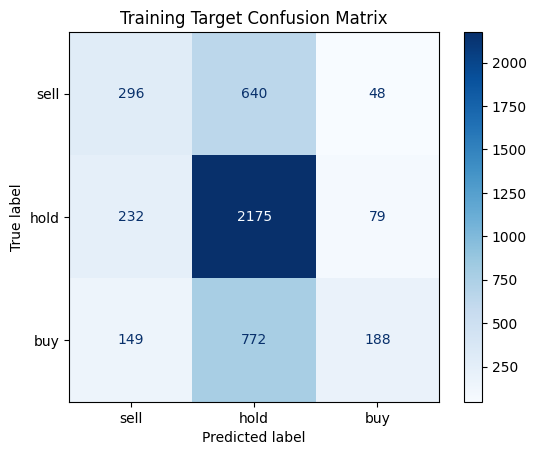


Accuracy by Confidence Bin:
50-60% Accuracy: 0.5420
60-70% Accuracy: 0.6108
70-80% Accuracy: 0.6911
80-90% Accuracy: 0.7908
90-100% Accuracy: 0.8261

Last 10 Rows of Data, Actual Targets, Predicted Targets, and Confidences:
                                              X_data  Actual Target  Predicted Target  Confidence
0  [[0.04649898028552006, 0.9698046181172292, 0.6...              1                 1    0.547349
1  [[0.1354180829367777, 0.4316163410301954, 0.39...              0                 1    0.706351
2  [[0.1700883752549286, 0.7921847246891652, 0.67...              0                 1    0.475700
3  [[0.14439157036029915, 0.15808170515097691, 0....              1                 1    0.552199
4  [[0.05139360978925901, 0.007104795737122558, 0...              1                 1    0.664165
5  [[0.04282800815771583, 0.03197158081705151, 0....              1                 1    0.884134
6  [[0.2318150917743032, 0.20603907637655416, 0.4...              2                 2    

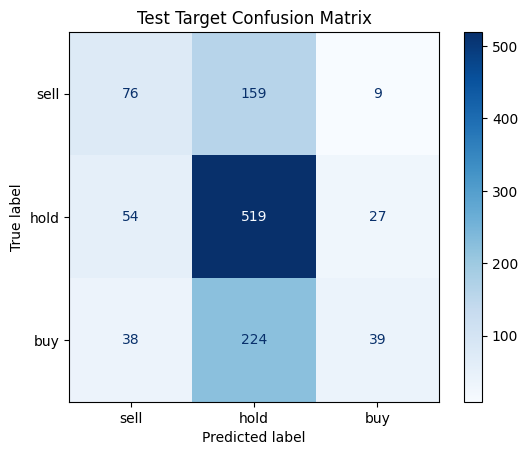


Accuracy by Confidence Bin:
50-60% Accuracy: 0.5142
60-70% Accuracy: 0.6135
70-80% Accuracy: 0.6438
80-90% Accuracy: 0.7634
90-100% Accuracy: 0.8000

Last 10 Rows of Data, Actual Targets, Predicted Targets, and Confidences:
                                              X_data  Actual Target  Predicted Target  Confidence
0  [[0.3184228416043508, 0.1616341030195382, 0.48...              2                 2    0.512380
1  [[0.010469068660774974, 0.19360568383658971, 0...              1                 1    0.844883
2  [[0.0600951733514616, 0.03552397868561279, 0.2...              2                 1    0.744314
3  [[0.6085656016315432, 0.07460035523978685, 0.0...              2                 0    0.495302
4  [[0.06281441196464989, 0.2380106571936057, 0.8...              1                 1    0.589780
5  [[0.09204622705642419, 0.06571936056838366, 0....              1                 1    0.673665
6  [[0.2610469068660775, 0.42628774422735344, 0.4...              1                 1    

In [34]:

def evaluate_model2(model, X, y_true, target_name="Target"):
    # Make predictions
    y_pred_prob = model.predict(X)

    # If y_pred_prob is a list (multiple targets), handle each output separately
    if isinstance(y_pred_prob, list):
        for i, y_pred_prob_single in enumerate(y_pred_prob):
            y_pred = np.argmax(y_pred_prob_single, axis=1)
            y_pred_confidence = np.max(y_pred_prob_single, axis=1)  # Confidence of each prediction
            y_true_single = y_true[:, i]  # True labels for this target

            # Calculate metrics
            accuracy = accuracy_score(y_true_single, y_pred)
            precision = precision_score(y_true_single, y_pred, average='weighted')
            recall = recall_score(y_true_single, y_pred, average='weighted')
            f1 = f1_score(y_true_single, y_pred, average='weighted')

            # Print metrics
            print(f"\n{target_name} {i+1} Metrics:")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")

            # Generate and display the confusion matrix
            conf_matrix = confusion_matrix(y_true_single, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['sell', 'hold', 'buy'])
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f"{target_name} {i+1} Confusion Matrix")
            plt.show()

            # Accuracy by confidence bins
            confidence_bins = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
            bin_results = {f"{int(confidence_bins[j]*100)}-{int(confidence_bins[j+1]*100)}%": [] for j in range(len(confidence_bins) - 1)}

            for j in range(len(y_pred)):
                conf = y_pred_confidence[j]
                correct = y_true_single[j] == y_pred[j]

                for k in range(len(confidence_bins) - 1):
                    if confidence_bins[k] <= conf < confidence_bins[k+1]:
                        bin_label = f"{int(confidence_bins[k]*100)}-{int(confidence_bins[k+1]*100)}%"
                        bin_results[bin_label].append(correct)
                        break

            # Display accuracy per confidence bin for this target
            print(f"\n{target_name} {i+1} Accuracy by Confidence Bin:")
            for bin_label, results in bin_results.items():
                if results:  # To avoid division by zero
                    bin_accuracy = np.mean(results)
                    print(f"{bin_label} Accuracy: {bin_accuracy:.4f}")
                else:
                    print(f"{bin_label} Accuracy: No predictions")

            # Display the last 10 rows of X data, actual targets, predictions, and confidences
            last_10_X = X[-10:]  # Last 10 rows of input features
            last_10_true = y_true_single[-10:]  # Last 10 actual target labels for this target
            last_10_pred = y_pred[-10:]  # Last 10 predicted labels for this target
            last_10_confidence = y_pred_confidence[-10:]  # Last 10 confidence scores for this target

            # Create a DataFrame to display this information neatly
            last_10_df = pd.DataFrame({
                'X_data': [x for x in last_10_X],   # Convert each row of X data to a list or array
                'Actual Target': last_10_true,
                'Predicted Target': last_10_pred,
                'Confidence': last_10_confidence
            })

            print(f"\nLast 10 Rows of Data, Actual Targets, Predicted Targets, and Confidences for {target_name} {i+1}:")
            print(last_10_df)
    else:
        # Single target case
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_pred_confidence = np.max(y_pred_prob, axis=1)  # Confidence of each prediction

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Print metrics
        print(f"\n{target_name} Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Generate and display the confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['sell', 'hold', 'buy'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{target_name} Confusion Matrix")
        plt.show()

        # Accuracy by confidence bins
        confidence_bins = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        bin_results = {f"{int(confidence_bins[j]*100)}-{int(confidence_bins[j+1]*100)}%": [] for j in range(len(confidence_bins) - 1)}

        for i in range(len(y_pred)):
            conf = y_pred_confidence[i]
            correct = y_true[i] == y_pred[i]

            for j in range(len(confidence_bins) - 1):
                if confidence_bins[j] <= conf < confidence_bins[j+1]:
                    bin_label = f"{int(confidence_bins[j]*100)}-{int(confidence_bins[j+1]*100)}%"
                    bin_results[bin_label].append(correct)
                    break

        # Display accuracy per confidence bin for this target
        print("\nAccuracy by Confidence Bin:")
        for bin_label, results in bin_results.items():
            if results:
                bin_accuracy = np.mean(results)
                print(f"{bin_label} Accuracy: {bin_accuracy:.4f}")
            else:
                print(f"{bin_label} Accuracy: No predictions")

        # Display the last 10 rows of X data, actual targets, predictions, and confidences
        last_10_X = X[-10:]  # Last 10 rows of input features
        last_10_true = y_true[-10:]  # Last 10 actual target labels
        last_10_pred = y_pred[-10:]  # Last 10 predicted labels
        last_10_confidence = y_pred_confidence[-10:]  # Last 10 confidence scores

        # Create a DataFrame to display this information neatly
        last_10_df = pd.DataFrame({
            'X_data': [x for x in last_10_X],   # Convert each row of X data to a list or array
            'Actual Target': last_10_true,
            'Predicted Target': last_10_pred,
            'Confidence': last_10_confidence
        })

        print("\nLast 10 Rows of Data, Actual Targets, Predicted Targets, and Confidences:")
        print(last_10_df)

# Evaluate on both training and test data for each target
if len(target_columns) == 1:
    evaluate_model2(model, X_train, y_train_cat.argmax(axis=1), target_name="Training Target")
    evaluate_model2(model, X_test, y_test_cat.argmax(axis=1), target_name="Test Target")
else:
    for i in range(len(target_columns)):
        evaluate_model2(model, X_train, y_train_cat[:, i], target_name=f"Training Target {i+1}")
        evaluate_model2(model, X_test, y_test_cat[:, i], target_name=f"Test Target {i+1}")


# **Optimizing the model**

In [ ]:
# hypermodel


def build_model(hp):
    # Input layer
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # LSTM layers with tunable parameters
    x = Bidirectional(
        LSTM(
            units=hp.Int('units_1', min_value=50, max_value=200, step=50),
            return_sequences=True
        )
    )(input_layer)
    x = Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = LSTM(
        units=hp.Int('units_2', min_value=25, max_value=150, step=25),
        return_sequences=False
    )(x)
    x = BatchNormalization()(x)

    # Fully connected layer
    x = Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu')(x)

    # Output layer
    if len(target_columns) == 1:
        output = Dense(num_classes, activation='softmax')(x)
        model = Model(inputs=input_layer, outputs=output)
    else:
        outputs = [Dense(num_classes, activation='softmax', name=f"output_{i}")(x) for i in range(len(target_columns))]
        model = Model(inputs=input_layer, outputs=outputs)

    # Optimizer with a tunable learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)

    # # Compile the model
    # model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Compile the model with updated optimizer
    if len(target_columns) == 1:
        # Single output case
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        # Multiple outputs - specify the same metric for each output
        metrics_list = ['accuracy'] * len(target_columns)

        # Use a dictionary to match each output name with its metric
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics_list)

    return model


In [ ]:
#tuner

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimize based on validation accuracy
    max_trials=10,             # Number of different hyperparameter combinations to try
    executions_per_trial=3,    # Number of models to build for each trial
    directory='my_tuning_directory',
    project_name='lstm_tuning'
)


In [ ]:

# Optional: Remove old tuning directory if you want to start fresh
shutil.rmtree('my_tuning_directory', ignore_errors=True)
shutil.rmtree('sample_data', ignore_errors=True)

In [ ]:
# hyperparameter search

# Use X_train and y_train as the training dataset
if len(target_columns) == 1:
    tuner.search(X_train, y_train_cat, epochs=10, validation_split=0.2)
else:
    # If multiple outputs, use a dictionary with target names
    y_train_dict = {f"output_{i}": y_train_cat[i] for i in range(len(target_columns))}
    tuner.search(X_train, y_train_dict, epochs=10, validation_split=0.2)


Trial 10 Complete [00h 17m 06s]
val_accuracy: 0.6185185114542643

Best val_accuracy So Far: 0.6238095362981161
Total elapsed time: 02h 06m 57s


In [ ]:
#best hyperparameters


# Define the EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Retrieve the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best hyperparameters
print("Best hyperparameters:")
print(f"Units in first LSTM layer: {best_hps.get('units_1')}")
print(f"Dropout rate after first LSTM layer: {best_hps.get('dropout_1')}")
print(f"Units in second LSTM layer: {best_hps.get('units_2')}")
print(f"Units in dense layer: {best_hps.get('dense_units')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

# Fit the best model on the full training data
if len(target_columns) == 1:
    # best_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_split=0.2)
    best_model.fit(
        X_train,
        y_train_cat,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr]
    )
else:
    y_train_dict = {f"output_{i}": y_train_cat[i] for i in range(len(target_columns))}
    # best_model.fit(X_train, y_train_dict, epochs=10, batch_size=32, validation_split=0.2)
    best_model.fit(
        X_train,
        y_train_dict,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr]
    )

Best hyperparameters:
Units in first LSTM layer: 200
Dropout rate after first LSTM layer: 0.4
Units in second LSTM layer: 150
Units in dense layer: 128
Learning rate: 0.00020458382064641792
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 492ms/step - accuracy: 0.9899 - loss: 0.0703 - val_accuracy: 0.9952 - val_loss: 0.2773 - learning_rate: 2.0458e-04
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 448ms/step - accuracy: 0.9935 - loss: 0.0429 - val_accuracy: 0.9952 - val_loss: 0.0937 - learning_rate: 2.0458e-04
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 450ms/step - accuracy: 0.9930 - loss: 0.0457 - val_accuracy: 0.9952 - val_loss: 0.0929 - learning_rate: 2.0458e-04
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 453ms/step - accuracy: 0.9920 - loss: 0.0524 - val_accuracy: 0.9952 - val_loss: 0.0503 - learning_rate: 2.0458e-04
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 45s 508ms/step - accuracy: 0.9925 - loss: 0.0501 - val_accuracy: 0.9952 - val_loss: 0.0364 - learning_rate: 2.0458e-04
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 572ms/step - accuracy: 0.9915 - loss: 0.0524 - val_accuracy: 0.9952 - val_loss: 0.0341 - learning_rate: 2.0458e-04
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 72s 446ms/step - accuracy: 0.98

In [ ]:
from google.colab import drive
from tensorflow.keras.models import load_model

# Mount Google Drive
drive.mount('/content/drive')


# Save the model to a folder in Google Drive
model_save_path = '/content/drive/My Drive/MyModels/best_lstm_model.h5'
best_model.save(model_save_path)

print(f"Model saved to: {model_save_path}")


# # Load the model from Google Drive
# loaded_model = load_model('/content/drive/My Drive/MyModels/best_lstm_model.h5')

# # Use the loaded model for predictions
# predictions = loaded_model.predict(X_test)


Mounted at /content/drive
Model saved to: /content/drive/My Drive/MyModels/best_lstm_model.h5


# **Combining predictions with original features/columns**

In [35]:
import numpy as np
import pandas as pd

# Model evaluation function to return predictions with indices and probabilities
def evaluate_model_with_indices(model, X, y_true, indices, target_name="Target"):
    # Make predictions
    y_pred_prob = model.predict(X)  # Get predicted probabilities
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to predicted labels

    # Capture the highest probability for the predicted class
    prediction_probability = np.max(y_pred_prob, axis=1)

    # Create a DataFrame with indices, true targets, predicted targets, and prediction probabilities
    result_df = pd.DataFrame({
        "True Target": y_true,
        "Predicted Target": y_pred,
        "Prediction Probability": prediction_probability
    }, index=indices)

    # Return the result DataFrame with indices
    return result_df

# Evaluate model on training and testing sets and collect predictions with indices and probabilities
if len(target_columns) == 1:
    merged_train = evaluate_model_with_indices(model, X_train, y_train_cat.argmax(axis=1), train_indices, target_name="Training Target")
    merged_test = evaluate_model_with_indices(model, X_test, y_test_cat.argmax(axis=1), test_indices, target_name="Test Target")
else:
    merged_train_list = []
    merged_test_list = []
    for i in range(len(target_columns)):
        merged_train = evaluate_model_with_indices(model, X_train, y_train_cat[:, i], train_indices, target_name=f"Training Target {i+1}")
        merged_test = evaluate_model_with_indices(model, X_test, y_test_cat[:, i], test_indices, target_name=f"Test Target {i+1}")

        # Append results to the lists
        merged_train_list.append(merged_train)
        merged_test_list.append(merged_test)

    # Combine results from multiple targets if needed
    merged_train = pd.concat(merged_train_list, axis=1)
    merged_test = pd.concat(merged_test_list, axis=1)


144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step


In [36]:
# Ensure the index is set to 'date' or the appropriate column in merged_df2
if 'date' in merged_df2.columns:
    merged_df2.set_index('date', inplace=True)

# Merge the prediction results back with the original X DataFrame (merged_df2)
# First for training data
final_train_df = merged_df2.join(merged_train, how='inner')  # 'inner' to match indices in merged_train
final_test_df = merged_df2.join(merged_test, how='inner')    # Same for testing data

# Display final DataFrames to check
print("Final Training DataFrame with Predictions:")
print(final_train_df.head())

print("\nFinal Testing DataFrame with Predictions:")
print(final_test_df.head())


Final Training DataFrame with Predictions:
            Close  3 Mo  10 Yr  SPY-Open  SPY-High  SPY-Low  SPY-Close  XOM-Open  XOM-High  \
2001-10-10  31.60  2.22   4.61     105.8     108.6    105.5      108.3     41.06     42.49   
2001-10-11  31.50  2.27   4.69     109.0     110.3    109.0      110.0     42.28     42.70   
2001-10-12  35.27  2.25   4.68     109.2     109.9    107.3      109.5     42.09     42.54   
2001-10-15  35.31  2.25   4.62     108.6     109.5    108.1      109.3     41.95     42.19   
2001-10-16  32.88  2.22   4.59     109.8     110.6    109.0      110.0     41.66     42.00   

            XOM-Low  XOM-Close      RSI_y     OBV_y  Aroon up_y  Aroon down_y    MACD_y  \
2001-10-10    40.90      42.28  59.908205  10453600  100.000000      7.142857  0.265248   
2001-10-11    41.77      42.09  58.861435  10756400  100.000000     14.285714  0.398035   
2001-10-12    41.51      42.29  59.642773  11409600   92.857143      7.142857  0.513490   
2001-10-15    41.41      41.

In [37]:
# Ensure the predictions DataFrames have the correct index (train_indices and test_indices)
# Assuming `merged_train` and `merged_test` have the same indices as the original data
merged_train.index = train_indices
merged_test.index = test_indices

# Merge the prediction results back with the original X DataFrame (merged_df2)
# First for training data
final_train_df = merged_df2.join(merged_train, how='inner')  # 'inner' to match indices in merged_train
final_train_df.sort_index(ascending=True, inplace=True)  # Sort training data by date

# Merge the prediction results back with the original X DataFrame (merged_df2)
# For testing data
final_test_df = merged_df2.join(merged_test, how='inner')  # 'inner' to match indices in merged_test
final_test_df.sort_index(ascending=True, inplace=True)  # Sort testing data by date

# Concatenate the training and testing DataFrames
final_combined_df = pd.concat([final_train_df, final_test_df], axis=0)

# Sort the final combined DataFrame by the date index in ascending order (oldest dates at the top)
final_combined_df.sort_index(ascending=True, inplace=True)


# Add new columns
final_combined_df['str1_p'] = np.random.rand(len(final_combined_df))  # Placeholder for str1_p
final_combined_df['str1_s'] = np.random.rand(len(final_combined_df))  # Placeholder for str1_s
final_combined_df['str1_c'] = np.random.rand(len(final_combined_df))  # Placeholder for str1_c
final_combined_df['str1_v'] = np.random.rand(len(final_combined_df))  # Placeholder for str1_v

final_combined_df['str2_p'] = np.random.rand(len(final_combined_df))  # Placeholder for str2_p
final_combined_df['str2_s'] = np.random.rand(len(final_combined_df))  # Placeholder for str2_s
final_combined_df['str2_c'] = np.random.rand(len(final_combined_df))  # Placeholder for str2_c
final_combined_df['str2_v'] = np.random.rand(len(final_combined_df))  # Placeholder for str2_v

final_combined_df['str3_p'] = np.random.rand(len(final_combined_df))  # Placeholder for str3_p
final_combined_df['str3_o'] = np.random.rand(len(final_combined_df))  # Placeholder for str3_o
final_combined_df['str3_c'] = np.random.rand(len(final_combined_df))  # Placeholder for str3_c
final_combined_df['str3_v'] = np.random.rand(len(final_combined_df))  # Placeholder for str3_v

final_combined_df['str4_p'] = np.random.rand(len(final_combined_df))  # Placeholder for str4_p
final_combined_df['str4_o'] = np.random.rand(len(final_combined_df))  # Placeholder for str4_o
final_combined_df['str4_c'] = np.random.rand(len(final_combined_df))  # Placeholder for str4_c
final_combined_df['str4_v'] = np.random.rand(len(final_combined_df))  # Placeholder for str4_v

final_combined_df['str5_p'] = np.random.rand(len(final_combined_df))  # Placeholder for str5_p
final_combined_df['str5_s'] = np.random.rand(len(final_combined_df))  # Placeholder for str5_s
final_combined_df['str5_o'] = np.random.rand(len(final_combined_df))  # Placeholder for str5_o
final_combined_df['str5_c'] = np.random.rand(len(final_combined_df))  # Placeholder for str5_c
final_combined_df['str5_v'] = np.random.rand(len(final_combined_df))  # Placeholder for str5_v


# Display the final combined DataFrame
print("Final Combined DataFrame (Training + Testing) Sorted by Date:")
print(final_combined_df.head(30))
print (len(final_combined_df))

Final Combined DataFrame (Training + Testing) Sorted by Date:
            Close  3 Mo  10 Yr  SPY-Open  SPY-High  SPY-Low  SPY-Close  XOM-Open  XOM-High  \
2001-10-10  31.60  2.22   4.61     105.8     108.6    105.5      108.3     41.06     42.49   
2001-10-11  31.50  2.27   4.69     109.0     110.3    109.0      110.0     42.28     42.70   
2001-10-12  35.27  2.25   4.68     109.2     109.9    107.3      109.5     42.09     42.54   
2001-10-15  35.31  2.25   4.62     108.6     109.5    108.1      109.3     41.95     42.19   
2001-10-16  32.88  2.22   4.59     109.8     110.6    109.0      110.0     41.66     42.00   
2001-10-17  35.08  2.22   4.59     111.1     111.2    107.7      107.7     41.80     42.35   
2001-10-18  34.95  2.19   4.58     107.8     108.2    106.8      107.4     40.80     41.26   
2001-10-19  34.11  2.19   4.63     107.0     107.9    106.0      107.4     40.29     40.90   
2001-10-22  32.25  2.22   4.63     107.3     109.6    107.2      109.5     40.49     41.34  

# **Strategy evaluation**

In [47]:
import pandas as pd
import numpy as np
import math

# Variable definitions
s_close = "XOM-Close"  # Column name representing the closing price of XOM stock
predictions = "Predicted Target"  # Column name for the prediction label (e.g., buy/sell/hold)
predictions2 = "Prediction Probability"  # Column for the prediction probability/confidence
funds1 = 50000  # Initial capital for strategy 1
funds2 = 2000  # Initial capital for strategy 2 (unused in the code)
shares_percentage = 0.25  # Fraction of capital to use for share purchases
prob = 0.45  # Probability threshold for making trading decisions

# Ensure the 'date' column is properly formatted as datetime
final_combined_df['date'] = pd.to_datetime(final_combined_df.index)

# Function to process current and past 5 days' data, including the first row
def process_current_and_past_data(df):

    global funds1
    global funds2
    global shares_percentage
    global s_close
    global predictions


    ccc=1
    cc=0
    cccc=0
    for i in range(len(df)):  # Start the loop from the first row
        # Get the current row of data (i-th row)
        current_row = df.iloc[i]
        #print(f"\nProcessing Past Rows for Date: {current_row.name}")
        if i==0:
          df.at[current_row.name, 'str1_v'] = funds1
          df.at[current_row.name, 'str2_v'] = funds1
          df.at[current_row.name, 'str3_v'] = funds1
          df.at[current_row.name, 'str1_s'] = math.floor(funds1 / current_row[s_close])
          dummy3= math.floor(funds1 / current_row[s_close])
          df.at[current_row.name, 'str1_c'] = funds1-math.floor(funds1 / current_row[s_close])*current_row[s_close]
          df.at[current_row.name, 'str2_c'] = funds1



          if current_row[predictions]==2 and current_row[predictions2]>prob:
            temp=math.floor((df.iloc[i]['str2_c']*shares_percentage ) / current_row[s_close])
            df.at[current_row.name, 'str2_s'] = temp
            df.at[current_row.name, 'str2_c'] = df.iloc[i]['str2_c']-temp*current_row[s_close]
            #df.at[current_row.name, 'str2_v'] = df.iloc[i]['str2_v']+temp*current_row[s_close]
            df.at[current_row.name, 'str2_p'] = "o"

          elif current_row[predictions]==0 and current_row[predictions2]>prob:
            temp=math.floor((df.iloc[i]['str2_c']*shares_percentage ) / current_row[s_close])
            df.at[current_row.name, 'str2_s'] = temp
            df.at[current_row.name, 'str2_c'] = df.iloc[i]['str2_c']+temp*current_row[s_close]
            #df.at[current_row.name, 'str2_v'] = df.iloc[i]['str2_c']-temp*current_row[s_close]
            df.at[current_row.name, 'str2_p'] = "o"

          elif current_row[predictions]==1 or (current_row[predictions]==0 and current_row[predictions2]<prob) or (current_row[predictions]==2 and current_row[predictions2]<prob):
            df.at[current_row.name, 'str2_p'] = "c"

        ccc=1
        if i > 0:

            df.at[current_row.name, 'str1_v'] = df.iloc[i-1]['str1_v']
            df.at[current_row.name, 'str1_c'] = df.iloc[i-1]['str1_c']
            df.at[current_row.name, 'str2_c'] = df.iloc[i-1]['str2_c']
            df.at[current_row.name, 'str2_v'] = df.iloc[i-1]['str2_v']
            start_idx = max(0, i - 5)  # Ensure we don't go out of bounds
            past_rows = df.iloc[start_idx:i]  # Slice for past 5 rows (not including current row)

            # Loop through the past 5 rows (excluding the current row)
            for j in range(len(past_rows)):
                past_row = past_rows.iloc[j]
                print(f"\nProcessing Past Rows for Date: {current_row.name}   {j}")
                if current_row[predictions]==2 and current_row[predictions2]>prob:
                    if past_row[predictions]==0 and past_row[predictions2]>prob and past_row["str2_p"]!="c":
                      temp=past_row["str2_s"]*current_row[s_close]
                      temp2=past_row["str2_s"]*past_row[s_close]-temp
                      df.at[current_row.name, 'str2_c'] = df.iloc[i]['str2_c']-temp
                      df.at[current_row.name, 'str2_v'] = df.iloc[i]['str2_v']+temp2
                      df.at[past_row.name, 'str2_p'] = "c"
                      past_row["str2_p"]="c"

                if current_row[predictions]==0 and current_row[predictions2]>prob:
                    if past_row[predictions]==2 and past_row[predictions2]>prob and past_row["str2_p"]!="c":
                      temp=past_row["str2_s"]*current_row[s_close]
                      temp2=temp-past_row["str2_s"]*past_row[s_close]
                      df.at[current_row.name, 'str2_c'] = df.iloc[i]['str2_c']+temp
                      df.at[current_row.name, 'str2_v'] = df.iloc[i]['str2_v']+temp2
                      df.at[past_row.name, 'str2_p'] = "c"
                      past_row["str2_p"]="c"

                if (current_row[predictions]==1 or current_row[predictions]==0 or current_row[predictions]==2) and j==0 and len(past_rows)==5:
                    if past_row[predictions]==2 and past_row[predictions2]>prob and past_row["str2_p"]!="c":
                      temp=past_row["str2_s"]*current_row[s_close]
                      temp2=temp-past_row["str2_s"]*past_row[s_close]
                      df.at[current_row.name, 'str2_c'] = df.iloc[i]['str2_c']+temp
                      df.at[current_row.name, 'str2_v'] = df.iloc[i]['str2_v']+temp2
                      df.at[past_row.name, 'str2_p'] = "c"

                    if past_row[predictions]==0 and past_row[predictions2]>prob and past_row["str2_p"]!= "c":
                      temp=past_row["str2_s"]*current_row[s_close]
                      temp2=past_row["str2_s"]*past_row[s_close]-temp
                      df.at[current_row.name, 'str2_c'] = df.iloc[i]['str2_c']-temp
                      df.at[current_row.name, 'str2_v'] = df.iloc[i]['str2_v']+temp2
                      df.at[past_row.name, 'str2_p'] = "c"



            if current_row[predictions]==2 and current_row[predictions2]>prob:
              temp=math.floor((df.iloc[i]['str2_c']*shares_percentage ) / current_row[s_close])
              df.at[current_row.name, 'str2_s'] = temp
              df.at[current_row.name, 'str2_c'] = df.iloc[i]['str2_c']-temp*current_row[s_close]
              #df.at[current_row.name, 'str2_v'] = df.iloc[i]['str2_v']+temp*current_row[s_close]
              df.at[current_row.name, 'str2_p'] = "o"
              ccc=1

            elif current_row[predictions]==0 and current_row[predictions2]>prob:
              temp=math.floor((df.iloc[i]['str2_v']*shares_percentage/ccc) / current_row[s_close])
              df.at[current_row.name, 'str2_s'] = temp
              df.at[current_row.name, 'str2_c'] = df.iloc[i]['str2_c']+temp*current_row[s_close]
              #df.at[current_row.name, 'str2_v'] = df.iloc[i]['str2_c']-df.iloc[i-1]['str2_c']
              df.at[current_row.name, 'str2_p'] = "o"
              ccc=ccc+1

            elif current_row[predictions]==1 or (current_row[predictions]==0 and current_row[predictions2]<prob) or (current_row[predictions]==2 and current_row[predictions2]<prob):
              df.at[current_row.name, 'str2_p'] = "c"
              df.at[current_row.name, 'str3_p'] = "c"
              df.at[current_row.name, 'str2_s'] = 0
              if ccc>1:
                ccc = ccc-1
                cccc = cccc+1
                if cccc==3:
                  cccc = 0
                  ccc=1

        #print(f"\nProcessing Past Rows for Date: {current_row.name}")
        if i>0:
          df.at[current_row.name, 'str1_v'] = df.iloc[i]['str1_v']+dummy3*(current_row[s_close]-df.iloc[i-1][s_close])
          #print(f"\nProcessing Past Rows for Date: {current_row.name}")
        if cc<5:
          cc=cc+1


    df.to_csv('output_file.csv', index=True)

process_current_and_past_data(final_combined_df)




Processing Past Rows for Date: 2001-10-11 00:00:00   0

Processing Past Rows for Date: 2001-10-12 00:00:00   0

Processing Past Rows for Date: 2001-10-12 00:00:00   1

Processing Past Rows for Date: 2001-10-15 00:00:00   0

Processing Past Rows for Date: 2001-10-15 00:00:00   1

Processing Past Rows for Date: 2001-10-15 00:00:00   2

Processing Past Rows for Date: 2001-10-16 00:00:00   0

Processing Past Rows for Date: 2001-10-16 00:00:00   1

Processing Past Rows for Date: 2001-10-16 00:00:00   2

Processing Past Rows for Date: 2001-10-16 00:00:00   3

Processing Past Rows for Date: 2001-10-17 00:00:00   0

Processing Past Rows for Date: 2001-10-17 00:00:00   1

Processing Past Rows for Date: 2001-10-17 00:00:00   2

Processing Past Rows for Date: 2001-10-17 00:00:00   3

Processing Past Rows for Date: 2001-10-17 00:00:00   4

Processing Past Rows for Date: 2001-10-18 00:00:00   0

Processing Past Rows for Date: 2001-10-18 00:00:00   1

Processing Past Rows for Date: 2001-10-18 00:00

<ipython-input-47-1085d939fa41>:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Streaming output truncated to the last 5000 lines.

Processing Past Rows for Date: 2006-10-25 00:00:00   0

Processing Past Rows for Date: 2006-10-25 00:00:00   1

Processing Past Rows for Date: 2006-10-25 00:00:00   2

Processing Past Rows for Date: 2006-10-25 00:00:00   3

Processing Past Rows for Date: 2006-10-25 00:00:00   4

Processing Past Rows for Date: 2006-10-26 00:00:00   0

Processing Past Rows for Date: 2006-10-26 00:00:00   1

Processing Past Rows for Date: 2006-10-26 00:00:00   2

Processing Past Rows for Date: 2006-10-26 00:00:00   3

Processing Past Rows for Date: 2006-10-26 00:00:00   4

Processing Past Rows for Date: 2006-10-27 00:00:00   0

Processing Past Rows for Date: 2006-10-27 00:00:00   1

Processing Past Rows for Date: 2006-10-27 00:00:00   2

Processing Past Rows for Date: 2006-10-27 00:00:00   3

Processing Past Rows for Date: 2006-10-27 00:00:00   4

Processing Past Rows for Date: 2006-10-30 00:00:00   0

Processing Past Rows for Date: 2006-10-30 00:00:00  

<ipython-input-47-1085d939fa41>:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Streaming output truncated to the last 5000 lines.

Processing Past Rows for Date: 2022-09-21 00:00:00   0

Processing Past Rows for Date: 2022-09-21 00:00:00   1

Processing Past Rows for Date: 2022-09-21 00:00:00   2

Processing Past Rows for Date: 2022-09-21 00:00:00   3

Processing Past Rows for Date: 2022-09-21 00:00:00   4

Processing Past Rows for Date: 2022-09-22 00:00:00   0

Processing Past Rows for Date: 2022-09-22 00:00:00   1

Processing Past Rows for Date: 2022-09-22 00:00:00   2

Processing Past Rows for Date: 2022-09-22 00:00:00   3

Processing Past Rows for Date: 2022-09-22 00:00:00   4

Processing Past Rows for Date: 2022-09-23 00:00:00   0

Processing Past Rows for Date: 2022-09-23 00:00:00   1

Processing Past Rows for Date: 2022-09-23 00:00:00   2

Processing Past Rows for Date: 2022-09-23 00:00:00   3

Processing Past Rows for Date: 2022-09-23 00:00:00   4

Processing Past Rows for Date: 2022-09-26 00:00:00   0

Processing Past Rows for Date: 2022-09-26 00:00:00  

In [48]:
import plotly.express as px
import pandas as pd


import plotly.io as pio
pio.renderers.default = 'colab'


# Load the CSV file into a DataFrame
file_path = 'output_file.csv'
df = pd.read_csv(file_path)


df['date'] = pd.to_datetime(df['date'])

# chart using Plotly
fig = px.line(
    df,
    x='date',
    y=['str1_v', 'str2_v'],
    labels={
        'Date': 'Date',
        'value': 'Portfolio Value',
        'variable': 'Strategy'
    },
    title='Portfolio Values Over Time'
)


fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Portfolio Value',
    legend_title_text='Strategies',
    hovermode='x unified',
)


fig.show()
